In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using DelimitedFiles


In [2]:
### Primero construimos la base de Fock
# Necesito la Combinatoria eso es con la funcion binomial(N,k)
binomial(9,2)

36

In [3]:
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [4]:
#Nos busca un indice k tal que los numeros posteriores son 0
#k=3 si |2,1,0,0,0> 
function search_k(M::Int64,n::Vector{Int64})
    k=1 #iniciamos en la pos 1
    for i=1:M #Recorreremos todas las posisiciones M para checar las j>i
        k=i #Nuestro primer prospecto a ser j
        flag=0 #Definimos una bandera si es
                # 1--> significa que encontro una n_{j} tal que los de adelante son 0
                #0--> no lo ha encontrado
        for j=k+1:M-1 #Revisaremos los n_{j} j>i si son cero
            if n[j]!=0 # si encientra una n_{j}!=0
                break  # ya no revises más
            elseif (j == M-1) # si j llega al penultimo valor entonces
                flag=1 # ya lo encontró
            end
        end
        if flag==1 # si la bandera es 1, ya encontro la k
            k=i # entonces esa i es la k
            break # ya no hace falta revisar más
        end
    
    if k==M # si no encontro ningun valor entonces signfica que tomaremos el penultimo valor
        k=M-1
    end
        
    end
    
    return k
end

search_k (generic function with 1 method)

In [5]:
function base_fock(N::Int64,M::Int64)
    D=binomial(N+M-1,N) #declaramos la variable de la dimension del espacio de Hilbert
    DM=zeros(Int64,(D,M)) #Aquí se colocaran las bases
    n=zeros(Int64,M) #Este vector va a ser el que modificaremos y usaremos para sobre escribir cada fila de DM
    
    DM[1,1]=N #El primer estado de la base
    n[1]=N    # Coincidde con el estado base
    
    l=1 # es un contador para colocar los demas estados
     #k es el indice donde despues de ese todos son ceros
    
    while n[M]!=N
        l+=1 #incrementamos el contador
        k=search_k(M,n) #buscamos la k
        n[k]=n[k]-1 #Primer paso del cambio n_{k}=n_{k}-1
        #Compienza el segundo paso de la suma n_{k+1}=n_{k}-1
        n[k+1]=N

        for i=1:k
            n[k+1]=n[k+1]-n[i]
        end
        #Cambiamos por ceros los n_{i} tales que i>=k+2
        for i=k+2:M
            n[i]=0
        end
        #Agregamos el estado n a la fila l
        DM[l,:]=n
    end
    
    
    return DM;
    
end

base_fock (generic function with 1 method)

In [6]:
# Operadores de Hamiltoniano
function ascenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    part=vector_base[mu]+1
    norm=sqrt(vector_base[mu]+1)
    if part>N
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function descenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    
    part=vector_base[mu]-1
    if vector_base[mu]<0
        norm=0.0
    else
        norm=sqrt(vector_base[mu])
    end
    
    if part<0
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function Numero_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    return vector_base[mu];
end

Numero_mu (generic function with 1 method)

In [7]:
##//Funcion para localizar vectores base//////////
function Buscador(vector_base::Vector{Int64},N::Int64,M::Int64)

    i0=N #indice para ayudarnos a que este fijo el num de particulas disponibles
    i1=0 #indice para ayudarnos a restar
    Sitios=2 #Numero de sitios que se quitan +1 (al principio se quita un sitio por eso es 2)

    contador=1

    for j=1:M
        while i0-i1 != vector_base[j]
            contador=contador+binomial(M-Sitios+i1,i1)
            i1+=1
        end
        i0=i1
        i1=0
        Sitios+=1
    end

    return contador
end

Buscador (generic function with 1 method)

In [8]:
#Hamiltoniano Cinético at_{m}*a_{m+1} + at_{m+1}*a_{m}
function H_J(J::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
            end
            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-J*at*a
                H[l,col]=H[l,col]-J*at*a
            end

        end
    end
    return H
end



#Esta es la parte     at_{mu}*n_{mu+nu}*a_{m+1} + at_{mu+1}*n_{mu+nu}*a_{m}
function H_K1(K1::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            for nu=0:1 #esto es para el operador de numero n_{mu+nu}
                n=bases[l,:] #Es el vector con el que se trabajara
                #Aplicamos las condiciones de frontera periodicas ANILLO
                if mu==M && nu==1
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(1,N,n)
                    at=ascenso_mu(mu,N,n)
                elseif mu==M && nu==0
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(mu,N,n)
                    at=ascenso_mu(mu,N,n)
                else
                    a=descenso_mu(mu+1,N,n)
                    num=Numero_mu(mu+nu,N,n)
                    at=ascenso_mu(mu,N,n)
                end
                if at*a*num != 0
                    col=Buscador(n,N,M)
                    H[col,l]=H[col,l]-K1*at*a*num
                    H[l,col]=H[l,col]-K1*at*a*num
                end
            end
        end
    end
    return H
end


#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_K2(K2::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                a=a*descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                a=a*descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            end

            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-K2*at*a
                H[l,col]=H[l,col]-K2*at*a
            end
        end
    end
    return H
end

#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_U(U::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    for l=1:D #Usaremos cada elemento de la base
        n=bases[l,:] #Es el vector con el que se trabajara
        for i=1:M
            H[l,l]=H[l,l]+U*0.5*(n[i]*(n[i]-1))
        end
    end
    return H

end


#El hamiltoniano es H = H_J + H_K1 + H_K2 + H_U

H_U (generic function with 1 method)

In [9]:
M=3 ## Numero de sitios
N=2 ## Numero de Bosones
D=binomial(N+M-1,N)
J=0.0
K1=1.0
K2=1.0
U=1.0
bases=base_fock(N,M)

H=H_J(J,N,M,D,bases)+H_U(U,N,M,D,bases) #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)
#eigvecs(H)[:,1] Este es el vector de energía E1 escrito en la base fock
#transpose(eigvecs(H))[:,1]           #Este es el vector de ede fock escrito en la base energías
#eigvals(H)
#eigvecs(H)[:,1]

6×6 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

In [10]:
Change_E_F=eigvecs(H)
#println(Change_E_F)
Change_F_E=transpose(Change_E_F)
# Condicion inicial, puede ser localizada
Vector_0_F=[1,0,0,0,0,0] #Para este ejemplo ψ(0)=|1,0,1>
# Hay que hacerel cambio de base antes de hacer la evolución temporal
Vector_0_E=Change_F_E*Vector_0_F
#println(Vector_0_E)
#Para la evolcución temporal necesitamos los eigenvalores
evals=eigvals(H)
#println(evals)
# Este es el operador evolución temporal
U_tempo(t)=exp.(-im*evals*t)

#Hay que hace una función con la condicion incial en E con evolución temporal U(t)
function Edo_evol_E(Vector_0, Evol_temp)
    Result=zeros(Complex{Float64},D)
    for i=1:D
        Result[i]=Vector_0[i]*Evol_temp[i]
    end
    return Result
end

Edo_E_t=Edo_evol_E(Vector_0_E, U_tempo(1)) # Este es el vector estado inicial evolucionado en el tiempo en la base de E
#println(Vector_0_E)
#println(Edo_E_t)
#Hay que pasarlo a la base de fock
#Edo_F_t=Change_E_F*Edo_E_t
Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(1)) #<--- Aqui evoluciona el tiempo

#HAcemos la matriz de densidad
rho_c=Edo_F_t*transpose(conj(Edo_F_t))
#println(rho_c[1,:])
# de la teoria tenemos dos deltas de dirac que dicen que cosas viven y mueren 
#\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N} * \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }

# para este ejemplo en particular 
#\delta_{n_{1}^{i}+n_{2}^{i}+n_{3}^{i}} , N} * \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }

# Base extendida
function base_2_ex(N::Int64)
    base_2_extendida=zeros(Int64,((N+1)^2,2))
    l=1
    for i=0:N
        for j=0:N
            base_2_extendida[l,:]=[i,j]
            l=l+1
        end
    end
    return base_2_extendida
end

base_2_extendida=base_2_ex(N)

function buscador_ext_bas(vector_base_ext::Vector{Int64},N::Int64)
    return ( vector_base_ext[1]*(N+1) )+1 +vector_base_ext[2]
end


# tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
n_nu=1
n_mu=3

#Matriz de densidad reducida
function rho_c_reducida_ex(n_nu::Int64,n_mu::Int64,N::Int64,D::Int64,
                                bases::Matrix{Int64},base_2_extendida::Matrix{Int64},T=false)
   
    rho_c_reducida_exten=zeros(ComplexF64,((N+1)^2,(N+1)^2))

    ### Revisamos cada uno de los elemtnos de la base extendida |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}|
    for i=1:(N+1)^2
        for j=1:(N+1)^2
            #### Esta es la primera delta de dirac (conservacion de particulas en la traza) --->
            ####  ---> \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }
            if sum(base_2_extendida[i,:])==sum(base_2_extendida[j,:])
                #println(sum(base_2_extendida[i,:]), sum(base_2_extendida[j,:]))
                ### Aqui es la segunda delta de dirac (Conservacion de particulas sin traza) --->
                ### ----->\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N}
                for k=1:D #Tecnicamente ya sabemos quienes cumplen eso son los de la base de fock
                    # Reviamos que elementos de la base de fock tienen n_{\nu}^{i} y n_{\mu}^{i} simultaneamente de la base extendida para i
                    # el k-esimo elemento es <k|\rho(t)| NOSE >
                    if bases[k,:][n_nu]==base_2_extendida[i,1] && bases[k,:][n_mu]== base_2_extendida[i,2] 
                        #println(i," ",j," ",base_2_extendida[i,:], " ", base_2_extendida[j,:])
                        #falta construir el NOSE que se compone de |n_{}^{i}...n_{\nu}^{j}...n_{\mu}^{j}>
                        #Con el <k| coinciden los que no son n_{\nu}^{j} n_{\mu}^{j}, entonces
                        NOSE=bases[k,:]
                        NOSE[n_nu],NOSE[n_mu]=base_2_extendida[j,:][1],base_2_extendida[j,:][2]
                        #println(Buscador(bases[k,:],N,M), " ", Buscador(NOSE,N,M))
                        rho_c_reducida_exten[i,j]=rho_c[Buscador(bases[k,:],N,M),Buscador(NOSE,N,M)]
                    end

                end

            else
                #println(0)
            end

        end
    end
    
    if T==false
        return rho_c_reducida_exten #<----------------------Resultado
    else
        rho_c_reducida_exten_trans_par=zeros(ComplexF64,((N+1)^2,(N+1)^2))
        ## Vamos a recorer cada elemento de la matriz de densidad reducida para transponerla
        for i=1:(N+1)^2
                for j=1:(N+1)^2
                ### Trasnponemos |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}| --->
                ###     ------>  |n_{\nu}^{i},n_{\mu}^{j}><n_{\nu}^{j},n_{\mu}^{i}|
                Transpo1=buscador_ext_bas( [base_2_extendida[i,:][1], base_2_extendida[j,:][2]] ,N)
                Transpo2=buscador_ext_bas( [base_2_extendida[j,:][1], base_2_extendida[i,:][2]] ,N)
                
                rho_c_reducida_exten_trans_par[Transpo1,Transpo2]=rho_c_reducida_exten[i,j]
                #println(i-1,",",j-1,"--->",Transpo1-1,",",Transpo2-1)
            end
        end
        return rho_c_reducida_exten_trans_par#<----------------------Resultado
    end
    
end


rho_c_reducida_ex (generic function with 2 methods)

In [11]:

##bases[k,:][n_nu]==base_2_extendida[i,1] && bases[k,:][n_mu]== base_2_extendida[i,2]

bases[4,:]

3-element Vector{Int64}:
 0
 2
 0

In [12]:
Buscador([4,0,4,0],8,4)

31

# EMPezamos a armar lo que hicimos

In [28]:
@time begin
    
    N=2 ## Numero de Bosones
    M=3 ## Numero de sitios
    D=binomial(N+M-1,N)
    J=0.01
    K1=0.0
    K2=0.0
    U=1.0
    bases=base_fock(N,M)
    base_2_extendida=base_2_ex(N) #BAses para dos sitios extendida
    # tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
    n_nu=1
    n_mu=2

    # Condicion inicial, puede ser localizada
    Vector_0_F=zeros(D) #Para este ejemplo ψ(0)=|1,0,1>
    Vector_0_F[1]=1


    # tiempo 
    dt=0.1
    Time_0=0
    Time_f=300
    times=Time_0:dt:Time_f

    H=H_J(J,N,M,D,bases)+H_U(U,N,M,D,bases) #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)
    #display(H)
    Change_E_F=eigvecs(H) # MAtriz cambio de base de Energias a Fock
    display(Change_E_F)
    Change_F_E=transpose(Change_E_F) # MAtriz cambio de base de Fock a Energias
    # Hay que hacerel cambio de base antes de hacer la evolución temporal
    Vector_0_E=Change_F_E*Vector_0_F
    display(Vector_0_E)
    #Para la evolcución temporal necesitamos los eigenvalores
    evals=eigvals(H)
    #display(evals)
    # Este es el operador evolución temporal
    U_tempo(t)=exp.(-im*evals*t)
    #print(U_tempo(1))


    #Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(0)) #<--- Aqui evoluciona el tiempo
    #display(Edo_F_t)
    #HAcemos la matriz de densidad
    #rho_c=Edo_F_t*transpose(conj(Edo_F_t))
    #rho_c_reducida_ex(n_nu,n_mu,N,D,bases,base_2_extendida,true)

    ## AQUI EMPIEZA LA DINAMICA## NEGATIVIDAD
    DATA_N=zeros(length(times))

    for (index,t) in enumerate(times)
        Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(t)) #<--- Aqui evoluciona el tiempo
        #print(t)
        #display(Edo_F_t)
        #HAcemos la matriz de densidad
        rho_c=Edo_F_t*transpose(conj(Edo_F_t))

        Eva=eigvals(rho_c_reducida_ex(n_nu,n_mu,N,D,bases,base_2_extendida,true))
        Negativity=0
        for i in Eva
            if i<0
                Negativity=Negativity+abs(i)
            end
        end
        DATA_N[index]=Negativity
    end
end

6×6 Matrix{Float64}:
 -0.0159913   0.0100979    -0.00583004   0.707035     -0.408207     0.577129
 -0.577129   -2.15973e-16  -0.816413     1.11022e-16   0.0116601   -0.0159913
 -0.577129    0.707035      0.408207    -0.0100979    -0.00583004  -0.0159913
 -0.0159913  -0.0100979    -0.00583004  -0.707035     -0.408207     0.577129
 -0.577129   -0.707035      0.408207     0.0100979    -0.00583004  -0.0159913
 -0.0159913   0.0           0.0116601    0.0           0.816413     0.577129

6-element Vector{Float64}:
 -0.015991307805430288
  0.010097919899431545
 -0.00583003677219171
  0.7070346752555382
 -0.4082066600852208
  0.5771287650152053

  0.307736 seconds (2.89 M allocations: 246.762 MiB, 16.78% gc time, 5.53% compilation time)


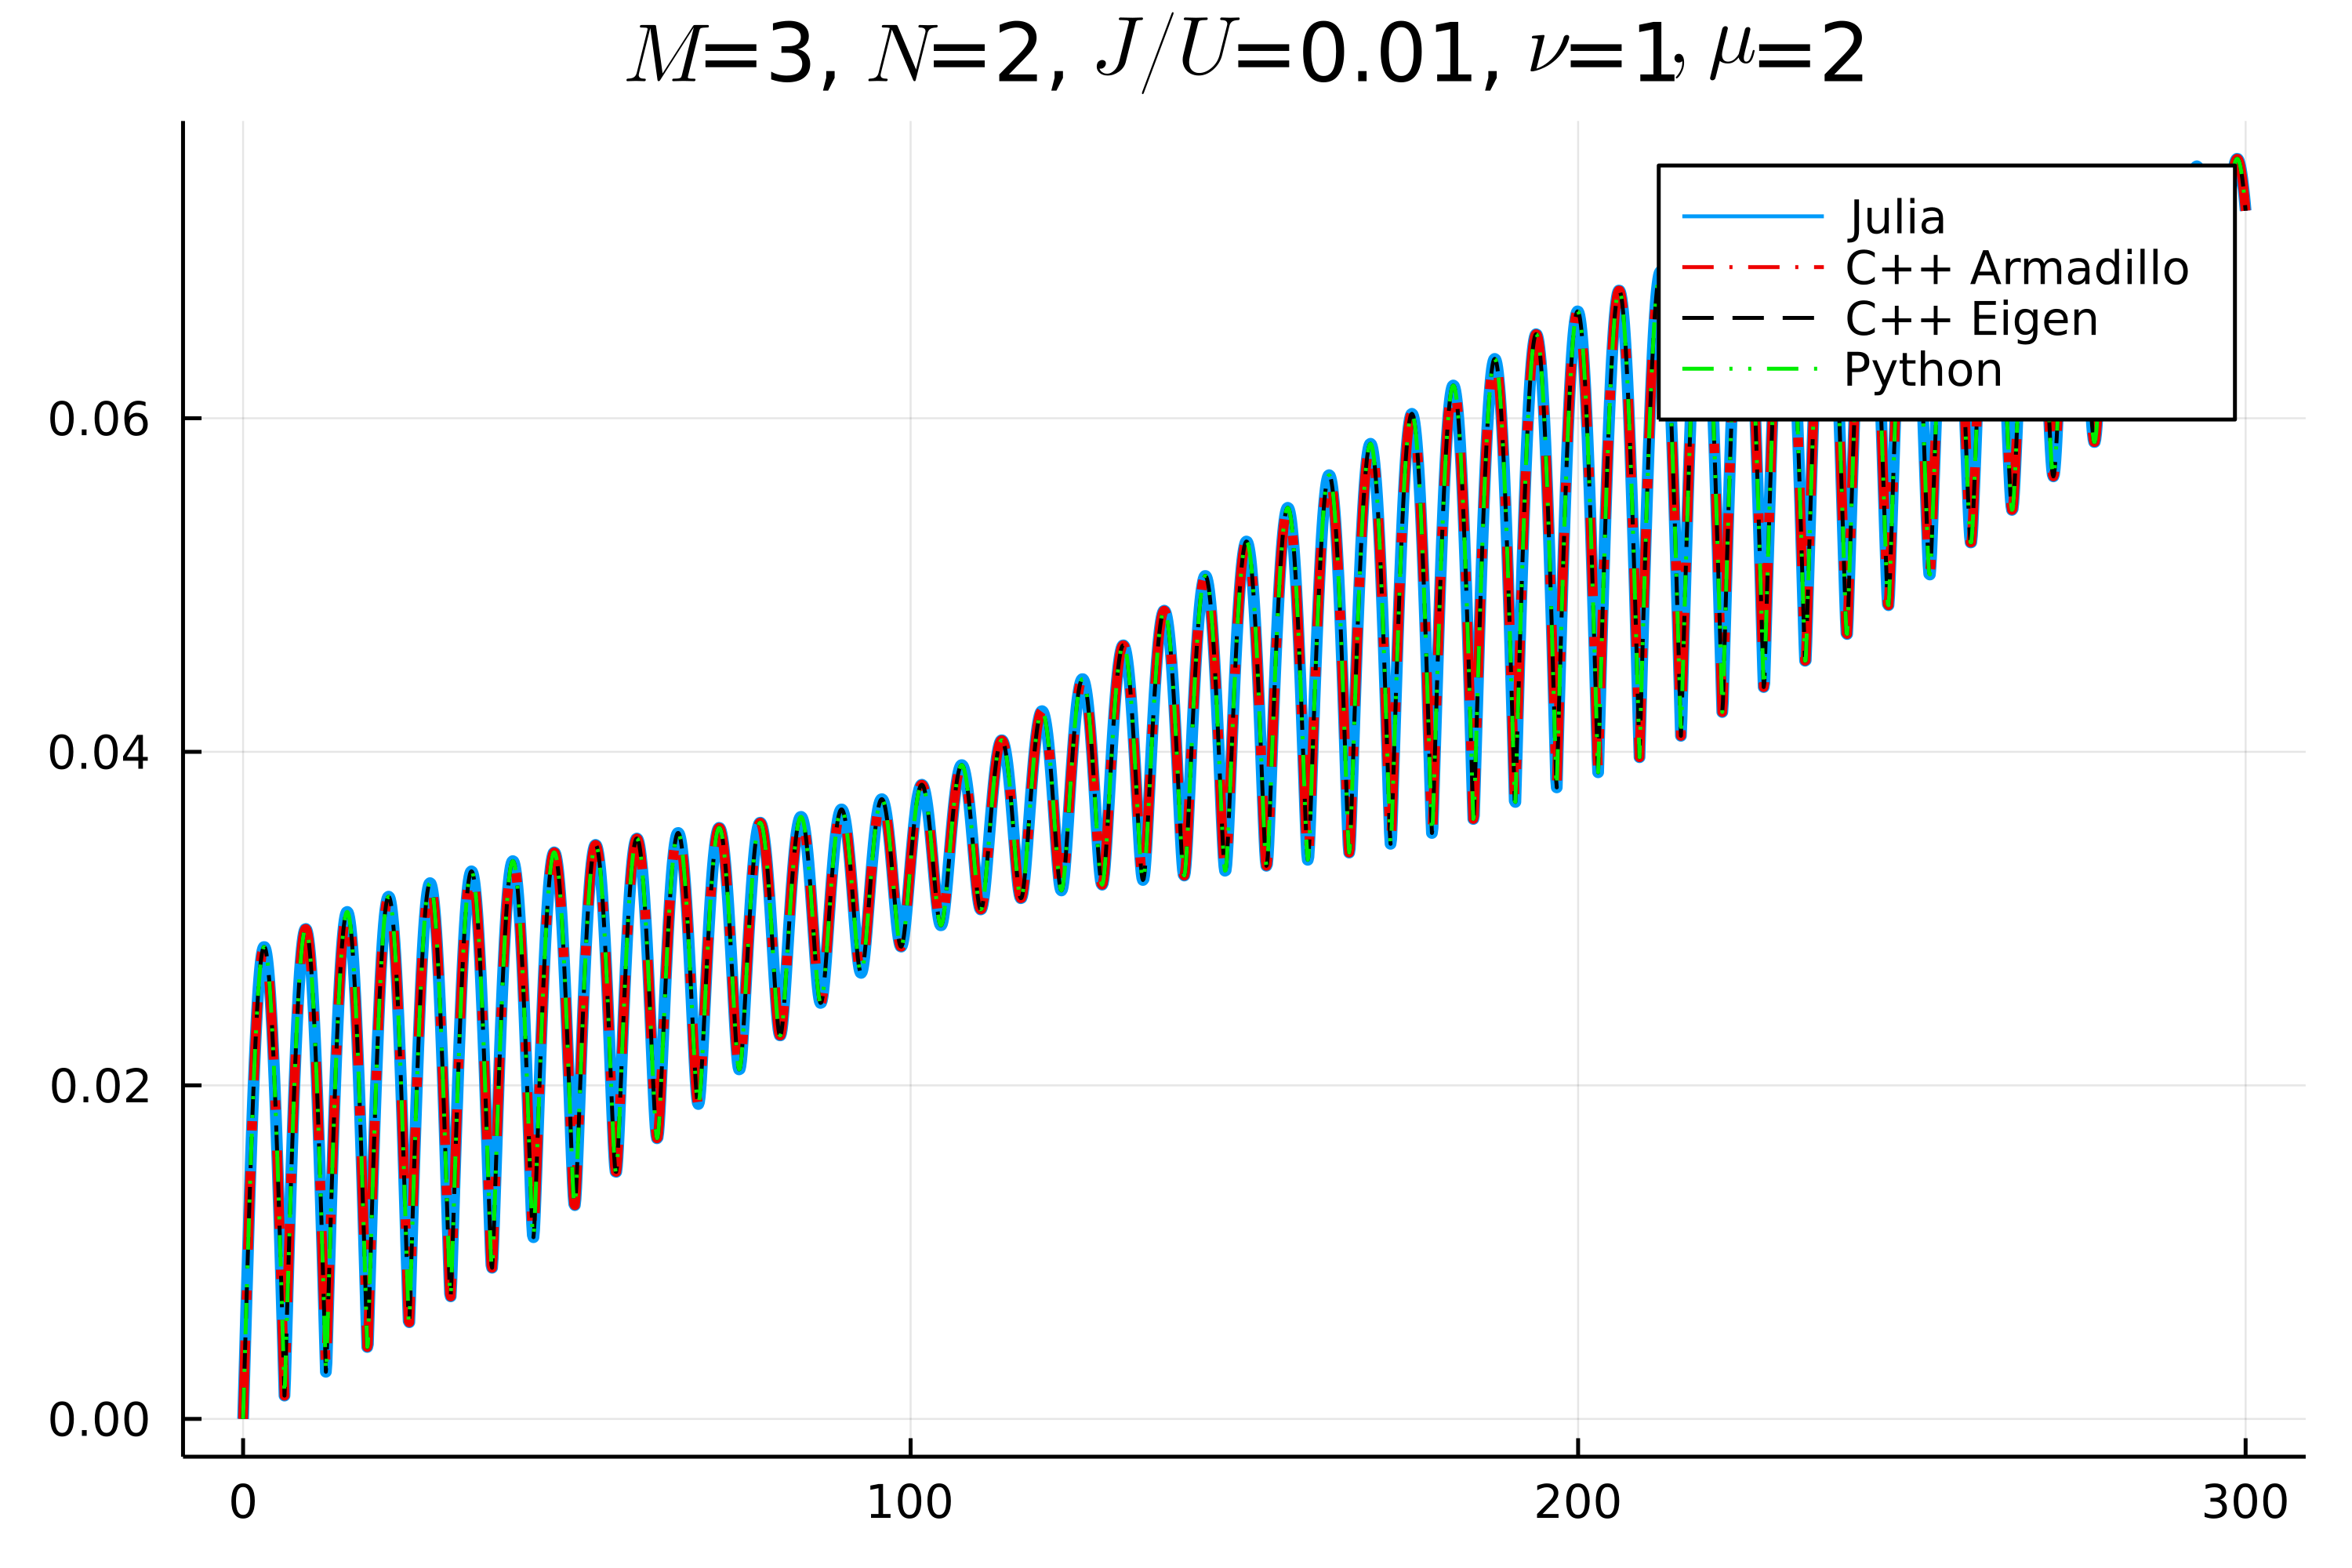

In [44]:
#Variar los sitios
DATA_N_A=readdlm("/home/sebas/Escritorio/Bose_Hubbard/Negativity.dat");
DATA_N_E=readdlm("/home/sebas/Escritorio/Bose_Hubbard/Negativity_EIGEN.dat");
DATA_N_P=readdlm("./Negativity_python.dat");


plot(times,DATA_N, lw=3.0,guidefont=fnt, fmt = :png, dpi=500, label="Julia",
    title=L"M"*"=$M, "*L" N"*"=$N, "*L" J/U"*"=$J, "* L"\nu"*"=$n_nu"*L",\mu"*"=$n_mu")#,ls=:dash)
plot!(DATA_N_A[:,2],DATA_N_A[:,1],label="C++ Armadillo", lw=2.5,linestyle=:dashdot,color="red2")
plot!(DATA_N_E[:,2],DATA_N_E[:,1],label="C++ Eigen",linestyle=:dash,color="black")
plot!(DATA_N_P[:,2],DATA_N_P[:,1],label="Python",linestyle=:dashdotdot,color="green2")

#Para variar factor de llenado
#plot!(times,DATA_N, lw=0.8,guidefont=fnt, fmt = :png, dpi=500, label=L"M"*"=$M ,"*L" N"*"=$N", 
#    title=L"\nu"*"=$n_nu, "*L"\mu"*"=$n_mu, "*L" J/U"*"=$J")////////

#Variar la J/U



In [17]:
Prueba=0
for i=1:D
    Resultado=(H*Change_E_F[:,i])-(evals[i]*Change_E_F[:,i])
    for j=1:D
        if abs(Resultado[j])>1e-15
           Prueba+=1 
        end
    end
end
Prueba

0

In [1]:
D

LoadError: UndefVarError: D not defined

In [148]:
# display(evals)
# display(Change_E_F)

In [18]:
savefig("./Figura_raro1.png")

In [24]:
N,M=2,10
binomial(N+M-1,N)

55

In [ ]:
#M=4
#N=4,6,8


In [324]:
### AQUI EMPIEZA LA DINAMICA## Entropia
DATA_S=zeros(length(times))

for (index,t) in enumerate(times)
    Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(t)) #<--- Aqui evoluciona el tiempo
    #HAcemos la matriz de densidad
    rho_c=Edo_F_t*transpose(conj(Edo_F_t))

    Eva=eigvals(rho_c_reducida_ex(n_nu,n_mu,N,D,bases,base_2_extendida,false))
    S=0
    for i in Eva
        if i>0
            S=S+(-i*log(i))
        end
    end
    DATA_S[index]=S
end

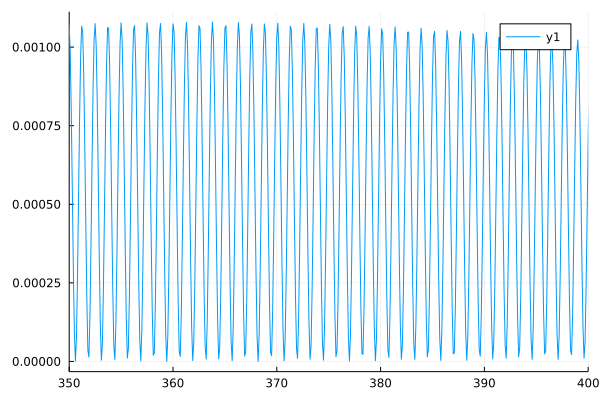

In [328]:
plot(times,DATA_S,xlims=(350,400))